
Pergunta 4: Crie um gráfico da "Fronteira Eficiente de Markovitz" entre dois ativos utilizando dados entre 01/Jan/2017 até 01/Fev/2022. (livre escolha do candidato a escolha dos ativos, e obtenção dos dados)



Importação das bibliotecas


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
import yfinance as yf


Definindo os tickers e o intervalo de tempo: 

- PETR4 e VALE3
- entre 01/Jan/2017 e 01/Fev/2022
 
É usado '.SA' no final do ticker pra pegar as cotações de empresas brasileiras na API do yahoo finance



In [10]:

tickers = 'PETR4.SA VALE3.SA'
start_date = datetime(2017, 1, 1)
end_date = datetime(2022, 2, 1)
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")


[*********************100%***********************]  2 of 2 completed



Calcula os retornos percentuais diários dos ativos com o método "pct_change" e armazena os resultados na variável "rtns".


In [11]:

close = data.loc[:, "Adj Close"]
rtns = close.pct_change()
n = len(close.columns)
equity = 10000.00



Calcular algumas partes estatísticas

'covar()' é covariancia
'pofo_return()' é o retorno experado do protfolio
'The sharpe()' é o índice de sharpe 
'cal()' é o montante a investir em cada ação baseado no índice de sharpe 'sr' e nos pesos 'x'


In [12]:
mean_rtn = rtns.mean() * 252 ** 0.5
sd = np.std(rtns)
var = sd ** 2

def covar(x):
    mtx = np.cov(rtns.dropna(), rowvar=False)
    for i in range(n):
        for j in range(n):
            mtx[i, j] = mtx[i, j] * x[i] * x[j]

    return mtx.sum() * 252 ** 0.5


def pofo_return(x, mean_rtn):
    return sum(x * mean_rtn)


def sharpe(x, mean_rtn):
    sd = covar(x) ** 0.5
    rtn = pofo_return(x, mean_rtn)

    return rtn / sd


def cal(x, sr):
    return x * sr


Encontrar os valores da fronteira eficiente


In [13]:
def constraint2(x, target):
    p_rtn = target
    for i in range(n):
        p_rtn = p_rtn - (x[i] * mean_rtn[i])

    return p_rtn


Isso limita o St Dev quando achar o retorno máximo


In [14]:

def constraint3(x):
    p_sd = 0.5

    return p_sd - (covar(x) ** 0.5)


con1 = {"type": "eq", "fun": constraint1}
con2 = {"type": "eq", "fun": constraint2}
con3 = {"type": "eq", "fun": constraint3}
cons = [con1, con2, con3]


x0 = [1 / n for i in range(n)]



Encontre os pesos para um portfolio de mínima variancia 


In [15]:

opt_var = minimize(covar, x0, method="SLSQP", tol=1e-10, constraints=con1)
min_var_w = opt_var.x



Encontre os pesos para um portfolio de máximo retorno


In [16]:

opt_rtn = minimize(
    pofo_return, x0, method="SLSQP", args=-mean_rtn, tol=1e-10, constraints=[con1, con3]
)
max_rtn_w = opt_rtn.x



Maximar o índice de sharpe


In [17]:

opt_sr = minimize(
    sharpe, x0, method="SLSQP", args=-mean_rtn, tol=1e-10, constraints=con1
)
max_sr_w = opt_sr.x


p_var = covar(max_sr_w)
p_sd = p_var ** 0.5
p_rtn = pofo_return(max_sr_w, mean_rtn)



Exibir os pesos de forma coesa


In [18]:
print('Optimized Portfolio Weights\n')
for i in range(n):
    print(
        f"{close.columns[i]}: {round(max_sr_w[i] * 100, 2)}%; ${round(equity * max_sr_w[i], 2)}"
    )

print(f'\nReturn: {round(p_rtn, 2) * 100}%, St Dev: {round(p_sd, 2) * 100}%')

max_sr_w



Optimized Portfolio Weights

PETR4.SA: 27.55%; $2755.42
VALE3.SA: 72.45%; $7244.58

Return: 2.0%, St Dev: 9.0%


array([0.27554224, 0.72445776])


Calcule o índice de sharpe, slope of CAL


In [19]:

sr = sharpe(max_sr_w, mean_rtn)



O seguinte código gera tamanhos para a frontera eficiente


In [20]:

import time

df_values = []
ll = -5
ul = 115
step = 0.0025
start = time.perf_counter()
for i in range(ll, ul):
    target = [i * step]

    con2 = {"type": "eq", "fun": constraint2, "args": target}

    ef_sol = minimize(covar, x0, method="SLSQP", tol=1e-10, constraints=[con1, con2])
    values = ef_sol.x.tolist()
    df_values.append(values)
stop = time.perf_counter()
print(f"Calculated in {round(stop - start, 3)} seconds")
ef_values = pd.DataFrame(
    df_values, columns=close.columns, index=[i for i in range(ll, ul)]
)


Calculated in 0.969 seconds



Isso gera dados para a fronteira eficiente


In [21]:

y = []
for i in range(ll, ul):
    value = round(covar(ef_values.loc[i, :]) ** 0.5 * 100, 2)
    y.append(value)
    


Isso gera pontos para a linha de alocação de capital


In [22]:

calues = []
for i in range(ll, ul):
    value = cal(i, sr)
    calues.append(value)

ef_values["return"] = [i * step * 100 for i in range(ll, ul)]
ef_values["ef"] = y
ef_values["cal"] = calues



Irá retorno para isso, isso será usado na verificação em the max_sr_w


In [23]:
ef_values["int"] = abs(ef_values["cal"] - ef_values["ef"])
idx = ef_values[ef_values["int"] == min(ef_values["int"])].index.values
w = ef_values.iloc[idx - ll, :-4]
# opt_w = []
# for i in range(n):
#     opt_w.append(w.iloc[0, i])


Plotar a fronteira eficiente e o cal


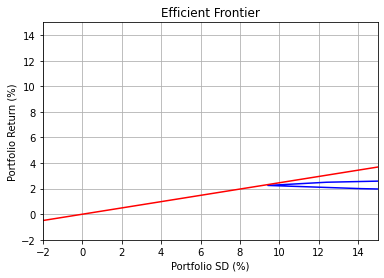

In [24]:
plt.plot(
    ef_values["ef"], ef_values["return"], "b-", ef_values.index, ef_values["cal"], "r-"
)
plt.title("Efficient Frontier")
plt.xlabel("Portfolio SD (%)")
plt.ylabel("Portfolio Return (%)")
plt.grid(True)
plt.xlim(-2, 15)
plt.ylim(-2, 15)
plt.show()
